## The Program

# The function library

In [1]:
import sys
sys.path.append('/opt/homebrew/lib/python3.10/site-packages')
sys.path.append('/opt/homebrew/lib/python3.11/site-packages')
sys.path.append('/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages')
import numpy as np
import pandas as pd
from osgeo import gdal
import shapely
from shapely.geometry import Point, LineString
import geopandas as gpd
import basemap
import math
import requests
import json
import fiona
from openpyxl import load_workbook
import random
from statistics import mean

#import xarray as xr
# import rioxarray # https://corteva.github.io/rioxarray/html/installation.html
import rasterio

#import rasterio.plot
#import rasterio.mask
#import rasterio.features
import rasterstats

#import cfgrib

#%matplotlib inline

In [35]:
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 2000)

In [36]:
layer_name = fiona.listlayers('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/city saved/OSM_Cities_Hun_Points.gpkg')
OSM_Cities_Hun = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/city saved/OSM_Cities_Hun_Points.gpkg',layer = layer_name[0])

In [37]:
#####

# read in Files of mine locations
hist_mines = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/Mining/historical_mines.dat')
contemp_mines = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/Mining/contemp_mines.dat')
miningfeature = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/Mining/m4eu20211209.gpkg',layer = 'miningfeatureoccurrence')
miningfeature.to_crs(epsg=3857, inplace=True)
hist_mines.to_crs(epsg=3857, inplace=True)
contemp_mines.to_crs(epsg=3857, inplace=True)
####

def calc_previous_population(campaigntime):
    """
    for settlements get the wikidata entity, download the json and extract the inception property P571
    also get population from wikidata.
    Calculate the population at campaign-time
    Delete Settlements without a wikidata item id
    Delete Settlements with inception time after Campaign time
    """
    # caps = settlement_layer.dataProvider().capabilities(
    layer_name = fiona.listlayers('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/city saved/OSM_Cities_Hun_Points.gpkg')
    OSM_Cities_Hun = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/city saved/OSM_Cities_Hun_Points.gpkg',layer = layer_name[0])
    
    OSM_Cities_Hun.set_index('osm_id', drop=False, inplace=True) #drop=False means that the COORDIDX collumn is not deleted
    OSM_Cities_Hun.index.names = ['IDX']
    
    # campaigntime = 1200
    pop_at_campaigntime_string = 'POP'+str(campaigntime)

    OSM_Cities_Hun['inception'] = 0.0 * OSM_Cities_Hun.shape[0]
    OSM_Cities_Hun[pop_at_campaigntime_string] = '' * OSM_Cities_Hun.shape[0]


    filt = OSM_Cities_Hun['wikidata'].notna() # only keep rows with a wikidata entry
    filtOSM=OSM_Cities_Hun.loc[filt] # apply filter
    features_to_delete = []
    for indx in filtOSM.index:
            # srcindx = feat.fieldNameIndex('wikidata') # srcindx sourceindex. Source of data, in this case the item Q
            fid = indx # to append to features_to_delete
            # print('Feature ID: ', feat.id())
            q = filtOSM.loc[indx,'wikidata'] # get the attribute, in this case the Q... srcindx is 146
            #print('Wikidata Item: ' , q)
            requeststring = 'https://m.wikidata.org/wiki/Special:EntityData/'+ str(q) + '.json' 
            x = requests.get(requeststring)
            y = json.loads(x.content) #convert json to python object
            try: # will fail if P571 == inception does not exist
                inception = y['entities'][q]['claims']['P571'][0]['mainsnak']['datavalue']['value']['time']
                IntInception = int(inception[:5])
                output = inception
                #print(output)
                #print(IntInception)
            except: # if fall through, append feature id to list of to-be-deleted features == rows
                IntInception = np.nan
                output = 'no_inception'
                features_to_delete.append(fid)
            #print('output: ', output)
            OSM_Cities_Hun.loc[indx, 'inception'] = IntInception
            if output != 'no_inception':
                if int(IntInception) > campaigntime: # this is crude. Year is first five of isostring. cast to int.
                        features_to_delete.append(fid) # leave only 1200 and earlier
            
            #print ('destindx: ', destindx)
            

            try: # if there is a wikidata entry for population, insert this into the dataframe
                temp_population = y['entities'][q]['claims']['P1082'][0]['mainsnak']['datavalue']['value']['amount'] #P1082
            except: 
                #print ('population not updated')
                temp_population = ''
            if not temp_population == '' and not math.isnan(IntInception):
                OSM_Cities_Hun.loc[indx,'population'] = temp_population
                # round(((1200 - to_int('Inception'))/4500)*to_int('population'))
                # formula from alexis. https://wiki.alexissmolensk.com/index.php/Settlements Heading 'Determining Settlement Population'
                OSM_Cities_Hun.loc[indx, pop_at_campaigntime_string] = round(((int(campaigntime) - round(OSM_Cities_Hun.loc[indx,'inception']))/4500)*int(OSM_Cities_Hun.loc[indx,'population']))
            else:
                 pass
                #print('calculation of campaign-time population failed')
            #print('End of loop---------')
    #print('Deletion part---------')
    #print (features_to_delete)
    # res = settlement_layer.dataProvider().deleteFeatures(features_to_delete) # delete all featuers without an inception
    
    # for i in features_to_delete:
    #         dropFilt = OSM_Cities_Hun['osm_id'] == i
    #         OSM_Cities_Hun.drop(dropFilt)
    #         # settlement_layer.deleteFeature(i) # https://gis.stackexchange.com/questions/316057/deleting-features-in-pyqgis
    # pass
    #         # don't update the feature https://gis.stackexchange.com/questions/316057/deleting-features-in-pyqgis
    return OSM_Cities_Hun

#######
hexgrid30km = gpd.read_file("/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/30KMHungaryClip.shp")
##########
hexgrid30km['COORDIDX'] = [''] * hexgrid30km.shape[0]
for index3, feature3 in  hexgrid30km.iterrows():
    hexgrid30km.loc[index3,'COORDIDX'] = str(feature3['COORDX']) + '.' + str(feature3['COORDY'])
######
hexgrid30km.set_index('COORDIDX', drop=False, inplace=True) #drop=False means that the COORDIDX collumn is not deleted
hexgrid30km.index.names = ['IDX']
#######
hexgrid30km['COORDIDX'] = hexgrid30km['COORDIDX'].apply(lambda x: str(x)) # just to make sure that index is str
######
settls = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/CityHungaryEPSG3857.shp')
########
hexgrid10km = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungary Copy.shp')
######
hexgrid10km.set_index('COORDIDX', drop=False, inplace=True) #drop=False means that the COORDIDX collumn is not deleted
hexgrid10km.index.names = ['IDX']
######
# open Alexis' Table of Hex-Types per Infrastructure
with open("/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/JSON/hex_generator_table.json", "r") as openfile:
    allInfras = json.load(openfile)
######
area = 301
#######
def add_settlement_to_hex(hexgrid30km,settls):
    """
    Takes a hexgrid and a settlement layer and returns the hexgrid with the settlements added.
    To Do: Could be implemented with sjoin much simpler
    """
    hexgrid30km['OriginalInfra'] = [0] * hexgrid30km.shape[0]
    area = 301
    Match_Settlements_Ids = []
    for index1, feature1 in  hexgrid30km.iterrows():
        Match_Settlements_Ids = []
        pop_in_cell = []
        for index2, feature2 in  settls.iterrows():
            if feature1['geometry'].contains(feature2['geometry']):
                MatchGridCOORDIDX = feature1['COORDIDX']
                Match_Settlements_Ids.append(str(index2))
                pop_in_cell.append(int(feature2['POP1200']))
                # print('match' )
        if Match_Settlements_Ids: #truth value testing of python list. 
            list_of_strings = []
            for number in Match_Settlements_Ids:
                list_of_strings.append(str(number))
                #print(round(sum(pop_in_cell)/300))
                # once to JSON ...
                #hexgrid30kmJSON.settl[MatchGridCOORDIDX] = ' '.join(list_of_strings) 
                #hexgrid30kmJSON.infra[MatchGridCOORDIDX] = round((sum(pop_in_cell))/area)
                # ... and one to dataframe
                filt = hexgrid30km['COORDIDX'] == MatchGridCOORDIDX
                hexgrid30km.loc[filt,'settl'] = ' '.join(list_of_strings) # with COORDIDX as index, filtering is no longer necessary
                #print('infra before update',hexgrid30km.loc[filt,'Infra'])
                # hexgrid30km.loc[filt,'Infra'] = round((sum(pop_in_cell))/area) commented out because otherwise double
                hexgrid30km.loc[filt,'OriginalInfra'] = round((sum(pop_in_cell))/area)
                #print('infra after update',hexgrid30km.loc[filt,'Infra'])
    return hexgrid30km
                
####### WHAT IS THE DIFFERENCE BETWEEN RING_AROUND AND HEX_GROUP?
def ring_around(center, hexgrid30km ,radius):
    """
    Takes a hex object, the corrdinates of the center and the radius and 
    returns a set with the coordinates of the hexes in the ring around 
    the center
    https://www.redblobgames.com/grids/hexagons/
    """
    if radius < 0:
        return set()
    if radius == 0:
        return set([center])

    # stuff to get hex ring. Read up on numpy to simplify
    # from https://github.com/RedFT/Hexy/blob/master/hexy/hexy.py
    # this is for pointy hex orientation, for flat top see comments
    NW = np.array((0, -1, 1)) # N
    NE = np.array((1, -1, 0)) # NE
    E = np.array((1, 0, -1))  # SE
    SE = np.array((0, 1, -1)) # S
    SW = np.array((-1, 1, 0)) # SW
    W = np.array((-1, 0, 1))  # NW
    ALL_DIRECTIONS = np.array([NW, NE, E, SE, SW, W, ])
    offset_ring = []



    # print('center: ', center)
    #print('hexgrid30km.x[center]', hexgrid30km.x[center])

    col = int(center.split('.')[0])
    row = int(center.split('.')[1])

    #col = hexgrid30km.x[center]
    #row = hexgrid30km.y[center]
    q = col
    r = row - (col + col%2) / 2 # https://www.redblobgames.com/grids/hexagons/#conversions
    # coordsqr = np.array([q,r])   # convert to pseudo-multidimensional array for get_ring
    cube_x = q
    cube_z = r
    cube_y = -q - r
    cube_coords = np.vstack((cube_x, cube_y, cube_z)).T

    rad_hex = np.zeros((6 * radius, 3))
    #print('rad_hex after initialization: \n', rad_hex)
    # https://github.com/RedFT/Hexy/blob/master/hexy/hexy.py get_ring
    count = 0
    for i in range(0, 6):
        for k in range(0, radius):
            rad_hex[count] = ALL_DIRECTIONS[i - 1] * (radius - k) + ALL_DIRECTIONS[i] * (k)
            #print ('dir:',i ,'rad_hex:\n ', rad_hex)
            count += 1
    #print('rad_hex all directions:\n', rad_hex)

    cube_ring =  np.squeeze(rad_hex) + cube_coords
    ax_ring = np.vstack((cube_ring[:, 0], cube_ring[:, 2])).T

    for i in range(len(ax_ring)):
        hex_tile = ax_ring[i]
        col = hex_tile[0]
        row = hex_tile[1] + (hex_tile[0] + (hex_tile[0]%2)) / 2
        intx = int(col)
        inty = int(row)
        strx = str(intx)
        stry = str(inty)
        strCoords = strx + '.' + stry
        offset_ring.append(strCoords)
    ring_on_map = set()
    for i in offset_ring:
        if i in hexgrid30km['COORDIDX']:
            ring_on_map.add(i)
        else:
            pass
               #print('COORDS not on grid_layer')
    # print('end of ring_around')
    return ring_on_map
########
def hex_group(center,radius):
    """
    Takes a hex object, the corrdinates of the center and the radius and 
    returns a set with the coordinates of the hexes in the ring around 
    the center
    """
    if radius < 0:
        return set()
    if radius == 0:
        return set([center])

    # stuff to get hex ring. Read up on numpy to simplify
    NW = np.array((0, -1, 1))
    NE = np.array((1, -1, 0))
    E = np.array((1, 0, -1))
    SE = np.array((0, 1, -1))
    SW = np.array((-1, 1, 0))
    W = np.array((-1, 0, 1))
    ALL_DIRECTIONS = np.array([NW, NE, E, SE, SW, W, ])
    offset_ring = []

    # print('center: ', center)
    col = int(center.split('.')[0])
    row = int(center.split('.')[1])
    q = col
    r = row - (col + col%2) / 2
    # coordsqr = np.array([q,r])   # convert to pseudo-multidimensional array for get_ring
    cube_x = q
    cube_z = r
    cube_y = -q - r
    cube_coords = np.vstack((cube_x, cube_y, cube_z)).T

    rad_hex = np.zeros((6 * radius, 3))
    #print('rad_hex after initialization: \n', rad_hex)
    count = 0
    for i in range(0, 6): # i is the index of the current direction (ranging from 0 to 5).
        for k in range(0, radius): # is the index in the inner loop (ranging from 0 to radius - 1), which determines how far along the direction vector we are
            rad_hex[count] = ALL_DIRECTIONS[i - 1] * (radius - k) + ALL_DIRECTIONS[i] * (k) # for i =0 the index is -1. Negative indexing means "the last element of list". This is intentional here
            #print ('dir:',i ,'rad_hex:\n ', rad_hex)
            count += 1
    #print('rad_hex all directions:\n', rad_hex)

    cube_ring =  np.squeeze(rad_hex) + cube_coords
    ax_ring = np.vstack((cube_ring[:, 0], cube_ring[:, 2])).T

    for i in range(len(ax_ring)):
        hex_tile = ax_ring[i]
        col = hex_tile[0]
        row = hex_tile[1] + (hex_tile[0] + (hex_tile[0]%2)) / 2
        intx = int(col)
        inty = int(row)
        strx = str(intx)
        stry = str(inty)
        strCoords = strx + '.' + stry
        offset_ring.append(strCoords)
    group = set()
    for i in offset_ring:
        group.add(i)

    #return group
    return offset_ring

#######
def edge_hexes(center):
    """
    hex_group applied to find edge hexes
    """
    offset_ring = []

    top_left = np.array((-1, -1, 2))
    left =  np.array((- 2, 1, 1))
    bottom_left = np.array((-1, 2, -1))
    bottom_right = np.array((1, 1, -2))
    right = np.array((2, -1 ,-1))
    top_right = np.array((1, -2, 1))
    EDGE_HEXES = np.array([top_left, left, bottom_left, bottom_right, right, top_right])


    col = int(center.split('.')[0])
    row = int(center.split('.')[1])
    q = col
    r = row - (col + col%2) / 2
    # coordsqr = np.array([q,r])   # convert to pseudo-multidimensional array for get_ring
    cube_x = q
    cube_z = r
    cube_y = -q - r
    cube_coords = np.vstack((cube_x, cube_y, cube_z)).T

    cube_ring = EDGE_HEXES + cube_coords

    ax_ring = np.vstack((cube_ring[:, 0], cube_ring[:, 2])).T

    for i in range(len(ax_ring)):
        hex_tile = ax_ring[i]
        col = hex_tile[0]
        row = hex_tile[1] + (hex_tile[0] + (hex_tile[0]%2)) / 2
        intx = int(col)
        inty = int(row)
        strx = str(intx)
        stry = str(inty)
        strCoords = strx + '.' + stry
        offset_ring.append(strCoords)
    edges = set()
    for i in offset_ring:
        edges.add(i)

    # return edges
    return offset_ring





###
# write hex types to hexgrid10km
def write_HexType_to_10km(hexgrid30km, hexgrid10km):
    for j in hexgrid30km.index:
        if hexgrid30km.loc[j,'Hex_Group'] !='':
            dict_of_groupJSON = hexgrid30km.loc[j,'Hex_Group']
            # print(dict_of_groupJSON)
            dict_of_group = json.loads(dict_of_groupJSON)

            dict_of_typeJSON = hexgrid30km.loc[j,'Hex_Type']
            dict_of_type = json.loads(dict_of_typeJSON)
            for key90, value90 in dict_of_group.items():
                for key91,value91 in dict_of_type.items():
                    if key90 == key91:
                        hexgrid10km.loc[value90,'HexType'] = value91
                    else:
                        #print('keys do not match for coord', value90)
                        pass
    return hexgrid10km
####


#########
def propagate(hex1_COORDS,hexgrid30km):
    """
    Propagate infrastructure from center to periphery.
    """
    radius = 0
    while radius < 40: # and round(hexgrid30km.loc[hexgrid30km['COORDIDX'] == str(hex1_COORDS), 'Infra'].item() * (1/2)** radius): # 40 is widest
    # while hex(radius) < max(height, length) and round(infra(COORD1) * (1/2)**i )> 0 

    # last_ring = ring_around(hex1coord, hexgrid30km, radius-1)
        this_ring = ring_around(hex1_COORDS, hexgrid30km, radius)#.union(hexes_on_rid)
        # print('this_ring: ', this_ring)
        next_ring = ring_around(hex1_COORDS, hexgrid30km, radius+1)#.union(hexes_on_rid)
        # print('next_ring: ',next_ring)
        for hex in this_ring:
            three_adjacent_hexes = set.union(ring_around(hex,hexgrid30km,1),next_ring)
            for adjacent_hex in three_adjacent_hexes:
                if float(hexgrid30km.loc[hex,'MeanElev']) >  float(hexgrid30km.loc[adjacent_hex,'MeanElev']):
                    diff = float(hexgrid30km.loc[hex,'MeanElev']) - float(hexgrid30km.loc[adjacent_hex,'MeanElev'])
                else:
                    diff = float(hexgrid30km.loc[adjacent_hex,'MeanElev']) - float(hexgrid30km.loc[hex,'MeanElev'])

                exponent = math.ceil(diff/150) # meters. If < 150 m result in 1, so that 1/2**1 = 1/2
                calculated_Infra = round(hexgrid30km.loc[hex,'update'] /(2**exponent))  #hexgrid30km.loc[hex,'update']
                # print('calculated_Infra',calculated_Infra)
                # print(' = round(hex.infra[hex1_COORDS]',hexgrid30km.loc[hex,'update'])
                # print(' /(2**exponent))',exponent)
                # print('hexgrid30km.loc[adjacent_hex,"update"] before update',hexgrid30km.loc[adjacent_hex,'update'],'type: ',type(hexgrid30km.loc[adjacent_hex,'update']))
                if hexgrid30km.loc[adjacent_hex,'update'] == 0 or hexgrid30km.loc[adjacent_hex,'update'] <= calculated_Infra:
                    hexgrid30km.loc[adjacent_hex,'update'] = calculated_Infra
                    # print('hexgrid30km.loc[adjacent_hex,"update"] after update',hexgrid30km.loc[adjacent_hex,'update'])
                else:
                    # print('no update of',adjacent_hex)
                    pass

        radius +=1 
    ## es fehlt hexgrid30km infra += hexgrid30km update
    for key6 in hexgrid30km.index:
         # print('key6', key6)
         hexgrid30km.loc[key6,'Infra'] += hexgrid30km.loc[key6,'update'] 
         # print('hexgrid30km.infra[key6]',hexgrid30km.infra[key6],' hexgrid30kmJSON.update[key6]',hexgrid30kmJSON.update[key6])

    return hexgrid30km 

####
hexgrid30km['Hex_Group'] = '' * hexgrid30km.shape[0]
#hexgrid30km['Hex_Group'] = hexgrid30km['Hex_Group'].apply(lambda x: {})
hexgrid30km['Edge_Hexes'] = '' * hexgrid30km.shape[0]
#hexgrid30km['Edge_Hexes'] = hexgrid30km['Hex_Group'].apply(lambda x: [])
#####

#########################################################################################################
# ToDo: make this generic?
#########################################################################################################
def small_hexes_in_big_hexes(hexgrid30km, hexgrid10km):
    """
    write coordinates. make a temporary centroid dict with coordinates for hex groups and edge hexes later. 
    """
    centroid = {}
    for key7 in hexgrid30km.index:
        centroid[key7] = ''

    # hexgrid30km spans entire world. Origin is at top left.
    offset_y = 392
    offset_x = 724
    y30 = 0 + offset_y
    x30 = 0 + offset_x
    x10 = 1
    y10 = 2

    size_y = 28 # 30kmhexes
    size_x = 39 # 30kmhexes

    # first odd columns with col indexes divisible by 2, see Bildschirm­foto 2024-03-17 um 15.23.44.png
    # The grid is “even-q” vertical layout, shoves even columns down.

    while y30 < (size_y + offset_y): # max 419
        while x30 < (size_x + offset_x): # max 762
            #print(str(x30)+'.'+ str(y30))
            #print(hexgrid30km.centroid[str(x30)+'.'+ str(y30)])
            # hexgrid30km[str(x30)+'.'+ str(y30), 'centroid'] = str(x10)+'.'+ str(y10)
            centroid[str(x30)+'.'+ str(y30)] = str(x10)+'.'+ str(y10)# temp var centroid better than col
            #print('hexgrid30km.centroid[',str(x30)+'.'+ str(y30),']', hexgrid30km.centroid[str(x30)+'.'+ str(y30)])
            #hexgrid30km.Hex_Group[str(x30)+'.'+ str(y30)].append(ring_around(hexgrid30km.centroid[str(x30)+'.'+ str(y30)],hexgrid30km,1))
            #hexgrid30km.Hex_Group = ring_around(hexgrid30km.centroid[str(x30)+'.'+ str(y30)],hexgrid30km,1)
            x30 += 2
            x10 += 6
        
        y30 += 1
        y10 += 3
        #reset x
        x30 = 0 + offset_x
        x10 = 1

        # print('new y loop even y: ', y30)


    # then even columns with col indexes not divisible by 2
    # reset: 
    y30 = 0 + offset_y
    x30 = 1 + offset_x # <<--- this is the only difference to the odd y loop
    x10 = 4
    y10 = 0

    while y30 < (size_y +  offset_y):
        while x30 < (size_x + offset_x):
            #print(hexgrid30km.centroid[str(x30)+'.'+ str(y30)])
            # hexgrid30km[str(x30)+'.'+ str(y30),'centroid'] = str(x10)+'.'+ str(y10)
            centroid[str(x30)+'.'+ str(y30)] = str(x10)+'.'+ str(y10) # temp var centroid better than col
            #hexgrid30km.Hex_Group[str(x30)+'.'+ str(y30)].append(ring_around(hexgrid30km.centroid[str(x30)+'.'+ str(y30)],hexgrid30km,1))
            x30 += 2
            x10 += 6

        y30 += 1
        y10 += 3

        #reset x
        x30 = 1 + offset_x # <<--- this is the only difference to the odd y loop
        x10 = 4
        #print('new y loop odd y: ', y30)


    # delete empty lists
    temp = {k: v for k, v in centroid.items() if v} # dictionary comprehension with conditional. https://www.programiz.com/python-programming/dictionary-comprehension
    centroid = temp
    # breakpoint()
    # find hex groups for centoids

    ############################################################################################################
    # Find hex groups for centroids
    ############################################################################################################

    for key10, value10 in centroid.items():  # check if centroid is in hexgrid30km
        if key10 in hexgrid30km.index:
        # breakpoint()
        # temp = hex_group(value10,1)
        # list_of_strings = [str(x) for x in temp]
        
            list = hex_group(value10,1) # list of ring around centroid.
            list.append(value10) # append the centroid to the hex group
            dict = {'HexA' : list[0], 'HexB': list[1], 'HexC':list[2],'HexD':list[3],'HexE':list[4],'HexF':list[5], 'HexG':list[6]}
            dictJSON = json.dumps(dict) # convert to JSON because the text field in the dataframe is a string
            hexgrid30km.at[key10, 'Hex_Group'] = dictJSON
    
    ## delete empty list
    # temp1 = {k: v for k, v in hexgrid30km.Hex_Group.items() if v}
    # hexgrid30km.Hex_Group = temp1

    # append centroid to hex group
    #for key11, value11 in hexgrid30km['centroid'].items():
    # for key11, value11 in centroid.items():
    #     if key11 in hexgrid30km.index:
    #         hexgrid30km[key11,'Hex_Group'].append(value11)

    # find edge hexes
    for key12, value12 in centroid.items():
        egdelist = edge_hexes(value12)
        egdeJSON = json.dumps(egdelist)
        hexgrid30km.at[key12, 'Edge_Hexes'] = egdeJSON

    # later access with
    """
    filt = hexgrid30km['Edge_Hexes'].astype(bool)# check if list is empty
    """
    # list comprehension returns a list and not a boolen mask
    # [x for x in hexgrid30km['Edge_Hexes'] if x]
    """
    for i in hexgrid30km.loc[filt,'Edge_Hexes']:
    """

    
    ## delete empty lists
    # temp2 = {k: v for k, v in hexgrid30km.Edge_Hexes.items() if v}
    # hexgrid30km.Edge_Hexes = temp2


    # for key13 in hexgrid30km['Hex_Group'].keys():
        
    #     hexgrid30km.at[key13,'Hex_Group'] = {'HexA' : hexgrid30km.Hex_Group[key13][0], 'HexB': hexgrid30km.Hex_Group[key13][1], 'HexC':hexgrid30km.Hex_Group[key13][2],'HexD':hexgrid30km.Hex_Group[key13][3],'HexE':hexgrid30km.Hex_Group[key13][4],'HexF':hexgrid30km.Hex_Group[key13][5], 'HexG':hexgrid30km.Hex_Group[key13][6]}
              
     


    return hexgrid30km
#######################################################################################################################
hexgrid30km['Hex_Type'] = '' * hexgrid30km.shape[0]
hexgrid10km['HexType'] = 0 * hexgrid10km.shape[0]



####
def edge_hex_type(hexgrid30km,hexgrid10km):
    """
    
    """
    # needs hex groups in 10 km hexes
    filt = hexgrid30km['Edge_Hexes'].str.len() !=0 # check if str is empty, 
    Edge_Hexes_on_grid = []

    for Edge_Hex_ListJSON in hexgrid30km.loc[filt,'Edge_Hexes']:
        Edge_Hex_List = json.loads(Edge_Hex_ListJSON)
        for Edge_Hex in Edge_Hex_List:
            if Edge_Hex in hexgrid10km.index:
                Edge_Hexes_on_grid.append(Edge_Hex)

    Edge_Hexes_on_grid = list(set(Edge_Hexes_on_grid)) # removes duplicates

    # has been updated, should work now
    COORDIDX_10km_Edge_Hex = {}
    ring_hex_types = []
    for this_Edge_Hex in Edge_Hexes_on_grid:
        ring_around_Edge = hex_group(this_Edge_Hex,1)
        for ring_hex in ring_around_Edge:
            if ring_hex in hexgrid10km['IDX'].to_list():
                # if ring_hex in COORDIDX_10km_HexGroup: # where in 10km grid or 30 km grid
                ring_hex_types.append(hexgrid10km.loc[hexgrid10km['IDX'] == ring_hex,'HexType'].to_list()[0]) # to_list() because it returns a series
                # else:
                    #print(ring_hex, 'not on Grid')
                    # pass
        if len(ring_hex_types) != 0:
            mean_type = round(mean(ring_hex_types))
        print("before: ", hexgrid10km.loc[hexgrid10km['IDX'] == this_Edge_Hex,'HexType'])    
        hexgrid10km.loc[hexgrid10km['IDX'] == this_Edge_Hex,'HexType'] = mean_type
        print("after:", hexgrid10km.loc[hexgrid10km['IDX'] == this_Edge_Hex,'HexType'])
        ring_hex_types = []

    return hexgrid10km
####

#####
def getHexGroup(allInfras,infra):
    """
    generates a dict of hex-Types for a 10km hex hex group. Input is Alexis' Table of Hex-Types per Infrastructure and the 30 km Infrastructure
    """


    while allInfras[infra] ==[]: # if there is no entry for the infra-value, reduce the infra valute until a non-empty row is met. So it "rounds down"
        infra = str(int(infra)-1)
    randIdx = random.randint(0,len(allInfras[infra])-1)
    randHexTypeDistro = allInfras[infra][randIdx]

    HexGroup = [0,0,0,0,0,0,0]
    HexGroupDict = {'HexA' : 0, 'HexB': 0, 'HexC':0,'HexD':0,'HexE':0,'HexF':0, 'HexG':0}


    HexTypeIdx = 0
    HexGroupIdx = 0
    while HexTypeIdx <= 7:
        count = 0
        while count < randHexTypeDistro[HexTypeIdx]: 
            HexGroup[HexGroupIdx] = HexTypeIdx +1
            count +=1
            HexGroupIdx +=1 # next Hex
        HexTypeIdx += 1
    
    randHexGropup = random.sample(HexGroup, 7)
    HexGroupDict = {'HexA' : randHexGropup[0], 'HexB': randHexGropup[1], 'HexC':randHexGropup[2],'HexD':randHexGropup[3],'HexE':randHexGropup[4],'HexF':randHexGropup[5], 'HexG':randHexGropup[6]}
    
    return json.dumps(HexGroupDict)



### 
hexgrid30km['Infra'] = [0] * hexgrid30km.shape[0]
hexgrid30km['update'] = [0] * hexgrid30km.shape[0]
hexgrid30km = add_settlement_to_hex(hexgrid30km,settls) # initialize

# first set_hammers

#############################
def set_bread(hexgrid10km):
    bread = {'rural' : {'0': -1,'1': 5, '2':4, '3':3 , '4':3, '5':3, '6':2, '7': 2, '8':1 },
            'settl' : {'0': -1,'1': 6, '2':5, '3': 4, '4':4, '5':4, '6':3, '7': 3, '8': 0}
             }

    hexgrid10km['Bread'] = 0 * hexgrid10km.shape[0] #initialize new column
    for i in hexgrid10km.index:
        hexgrid10km.loc[i,'Bread'] = 0
        # if any([pd.notna(hexgrid10km.loc[i,'main_commo']), pd.notna(hexgrid10km.loc[i,'commodity']),pd.notna(hexgrid10km.loc[i,'IDminingfe'])]):
        # hexgrid10km.loc[i,'Bread'] = -1
        # Hextype of corner hexes is 0!
        if pd.notna(hexgrid10km.loc[i,'IDsettl']):
            hexgrid10km.loc[i,'Bread'] = bread['settl'][hexgrid10km.loc[i,'HexType'].astype(int).astype(str)]
        else:
            hexgrid10km.loc[i,'Bread'] = bread['rural'][hexgrid10km.loc[i,'HexType'].astype(int).astype(str)]
    return hexgrid10km

### 

Hextype of Corner Hexes is 0. Need to revise

In [38]:
hexgrid10km = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungary Copy with Bread.shp')

In [39]:
bread = {'rural' : {'0': -1,'1': 5, '2':4, '3':3 , '4':3, '5':3, '6':2, '7': 2, '8':1 },
            'settl' : {'0': -1,'1': 6, '2':5, '3': 4, '4':4, '5':4, '6':3, '7': 3, '8': 0}
            }

Addressing Cells: If you want to find a cell with a certain index, this is how you do it

In [ ]:
#If you want to find a cell with a certain index, this is how you do it
df.loc[df['IDX']== '10.14','Bread']
# If you want to show multiple columns
df.loc[df['IDX']== '10.14',['Bread','HexType','IDsettl']]

## Find HexType for Edge Hexes

In [ ]:
with open("/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/JSON/Edge_Hexes_on_grid.json", "r") as openfile:
    Edge_Hexes_on_grid = json.load(openfile)
    ring_hex_types = []
    for this_Edge_Hex in Edge_Hexes_on_grid:
        ring_around_Edge = hex_group(this_Edge_Hex,1)
        for ring_hex in ring_around_Edge:
            if ring_hex in hexgrid10km['IDX'].to_list():
                # if ring_hex in COORDIDX_10km_HexGroup: # where in 10km grid or 30 km grid
                ring_hex_types.append(hexgrid10km.loc[hexgrid10km['IDX'] == ring_hex,'HexType'].to_list()[0]) # to_list() because it returns a series
                # else:
                    #print(ring_hex, 'not on Grid')
                    # pass
        if len(ring_hex_types) != 0:
            mean_type = round(mean(ring_hex_types))
        # print("before: ", hexgrid10km.loc[hexgrid10km['IDX'] == this_Edge_Hex,'HexType'])    
        hexgrid10km.loc[hexgrid10km['IDX'] == this_Edge_Hex,'HexType'] = mean_type
        # print("after:", hexgrid10km.loc[hexgrid10km['IDX'] == this_Edge_Hex,'HexType'])
        ring_hex_types = []

    hexgrid10km.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungarybreadRevised.shp')



before:  172    0.0
Name: HexType, dtype: float64
after: 172    8.0
Name: HexType, dtype: float64
before:  3814    0.0
Name: HexType, dtype: float64
after: 3814    8.0
Name: HexType, dtype: float64
before:  1526    0.0
Name: HexType, dtype: float64
after: 1526    6.0
Name: HexType, dtype: float64
before:  6071    0.0
Name: HexType, dtype: float64
after: 6071    8.0
Name: HexType, dtype: float64
before:  6617    0.0
Name: HexType, dtype: float64
after: 6617    7.0
Name: HexType, dtype: float64
before:  9868    0.0
Name: HexType, dtype: float64
after: 9868    5.0
Name: HexType, dtype: float64
before:  5800    0.0
Name: HexType, dtype: float64
after: 5800    8.0
Name: HexType, dtype: float64
before:  9617    0.0
Name: HexType, dtype: float64
after: 9617    8.0
Name: HexType, dtype: float64
before:  4661    0.0
Name: HexType, dtype: float64
after: 4661    8.0
Name: HexType, dtype: float64
before:  3259    0.0
Name: HexType, dtype: float64
after: 3259    8.0
Name: HexType, dtype: float64
be

## Set_Bread

In [ ]:
# Read in, now truncated colum lables
def set_bread(hexgrid10km):
    bread = {'rural' : {'0': -1,'1': 5, '2':4, '3':3 , '4':3, '5':3, '6':2, '7': 2, '8':1 },
            'settl' : {'0': -1,'1': 6, '2':5, '3': 4, '4':4, '5':4, '6':3, '7': 3, '8': 0}
             }

    hexgrid10km['Bread'] = 0 * hexgrid10km.shape[0] #initialize new column
    for i in hexgrid10km.index:
        hexgrid10km.loc[i,'Bread'] = 0
        # if any([pd.notna(hexgrid10km.loc[i,'main_commo']), pd.notna(hexgrid10km.loc[i,'commodity']),pd.notna(hexgrid10km.loc[i,'IDminingfe'])]):
        # hexgrid10km.loc[i,'Bread'] = -1
        # Hextype of corner hexes is 0!
        if pd.notna(hexgrid10km.loc[i,'IDsettl']):
            hexgrid10km.loc[i,'Bread'] = bread['settl'][hexgrid10km.loc[i,'HexType'].astype(int).astype(str)]
        else:
            hexgrid10km.loc[i,'Bread'] = bread['rural'][hexgrid10km.loc[i,'HexType'].astype(int).astype(str)]
    return hexgrid10km

hexgrid10km = set_bread(hexgrid10km)

In [ ]:
hexgrid10km.loc[hexgrid10km['IDX'] == '2.81','HexType'] 

172    8.0
Name: HexType, dtype: float64

In [ ]:
hexgrid10km = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungarybreadRevised.shp')

In [ ]:
hexgrid10km.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungarybreadRevised.shp')


In [ ]:
# You cannot find a Cell according to HexType because it is float due to imprecise compaqrisons. You have to round the float to an int with astype(int) 
hexgrid10km.loc[hexgrid10km['HexType'].astype(int) == 7, ['HexType','Bread','IDX']]

,HexType,Bread,IDX
17,7.0,0,0.67
28,7.0,0,0.56
32,7.0,2,0.52
35,7.0,2,0.49
37,7.0,0,0.47
...,...,...,...
7725,7.0,0,90.8
7794,7.0,2,91.24
7808,7.0,0,91.10
7889,7.0,0,92.14


In [ ]:
bread['settl'][hexgrid10km.loc[20,'HexType'].astype(int).astype(str)]

0

In [ ]:
# reload to reset
# hexgrid10km = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungary Copy3.shp')
# hexgrid10km.drop(range(10200,10219), inplace=True)
# settls = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/CityHungaryEPSG3857.shp')

# Now the calls to the functions

In [ ]:
# hexgrid10km[hexgrid10km.index.duplicated()]
# https://saturncloud.io/blog/how-to-drop-duplicated-index-in-a-pandas-dataframe-a-complete-guide/

In [ ]:
OSM_Cities_Hun  = calc_previous_population(1200) # year of campaign time
###
filt2 = hexgrid30km['settl'].notnull() 
for hex in hexgrid30km.loc[filt2,'COORDIDX']: # go through all hexes with settlements
    # print('hex', hex, 'type:', type(hex))
    hexgrid30km['update'] = [0] * hexgrid30km.shape[0] # set to zero
    hexgrid30km.loc[hex,'update'] = round(hexgrid30km.loc[hex,'OriginalInfra']) 
    hexgrid30km = propagate(hex,hexgrid30km) # propagate infrastructure to neighbours
    #breakpoint()abs
    pass

###


hexgrid30km = small_hexes_in_big_hexes(hexgrid30km) # attach 10km hexes to 30km hexesx
###
# iterate over collumn hex type and fill with a randowm hex group according to infrastructure.
for key17 in hexgrid30km.index:
    infra = hexgrid30km.loc[key17,'Infra']
    if infra > 448:
        infra = 448
    infra = str(int(infra)) 
    hexgrid30km.at[key17,'Hex_Type'] = getHexGroup(allInfras,infra)

###
hexgrid10km = write_HexType_to_10km(hexgrid30km, hexgrid10km)
###
hexgrid10km = edge_hex_type(hexgrid30km,hexgrid10km)
###
# hexgrid10km.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungary Copy4.shp')
###
hexgrid10km = gpd.sjoin(hexgrid10km, settls, how ="left", predicate='contains') # What if there are multiple Selltlements in one hex?
hexgrid10km.rename(columns={'index_right':'IDsettl'}, inplace=True)
hexgrid10km = gpd.sjoin(hexgrid10km,miningfeature,how='left',predicate='contains')
# this creates new rows if there are multiple matches. See https://stackoverflow.com/questions/916414/how-can-a-left-outer-join-return-more-records-than-exist-in-the-left-table
hexgrid10km.rename(columns={'index_right':'IDminingfeature'}, inplace=True)
hexgrid10km.drop_duplicates(subset='geometry', keep='first', inplace=True) # this is what i want.
hexgrid10km = gpd.sjoin(hexgrid10km,contemp_mines,how='left',predicate='contains')
hexgrid10km.rename(columns={'index_right':'IDcontemp_mines'}, inplace=True) # rename to avoid duplicate column names
hexgrid10km.drop_duplicates(subset='geometry', keep='first', inplace=True) # this is what i want.
hexgrid10km = gpd.sjoin(hexgrid10km,hist_mines,how='left',predicate='contains') # left join because not all hexes have a historical mine
hexgrid10km.rename(columns={'index_right':'IDhist_mines'}, inplace=True) # rename to avoid duplicate column names
#hexgrid10km.set_index('IDX', inplace=True) #drop=False means that the COORDIDX collumn is not deleted
hexgrid10km.drop_duplicates(subset='geometry', keep='first', inplace=True) # this is what i want.
hexgrid10km = hexgrid10km.loc[~hexgrid10km.index.duplicated(keep='first')] # eliminates lines with duplicate index
###
hexgrid10km = set_bread(hexgrid10km)
###
hexgrid10km.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungary Copy with Bread.shp')
###

# Random bits and ends:

In [ ]:
mineraloccurrence=gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/Mining/m4eu20211209.gpkg', layer='commodity')

In [ ]:
contemp_mines.head()

In [ ]:
# hexgrid30km.to_file("/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/30KMHungaryClipCopy4.shp")

In [ ]:
# hexgrid10km.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungary Copy4.shp')

In [ ]:
# OSM_Cities_Hun.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/city saved/OSM_Cities_Hun_Points_With_POP.gpkg', driver='GPKG', layer='place_city')

In [ ]:
hexgrid10km.head()

In [ ]:
%debug

In [ ]:
hexgrid30km['update'].unique()

In [ ]:
hexgrid30km.plot(column = 'Infra')

In [ ]:
hexgrid30km.loc[filt2,'COORDIDX']

In [ ]:
hexgrid30km.loc[hexgrid30km['COORDIDX'] == hex1_COORDS, 'Infra']

In [ ]:
test = hexgrid30km['COORDIDX'] == hex1_COORDS

In [ ]:
hexgrid30km.loc[hexgrid30km['COORDIDX'] == str(hex1_COORDS), 'Infra'].item()

In [ ]:
#hexgrid30km['update']

In [ ]:
test = gpd.sjoin(hexgrid30km, settls, how='left', op = 'contains')

In [ ]:
def to_null(x):
    x = 0
    return x
hexgrid30km['Infra'] = hexgrid30km['Infra'].apply(to_null)

In [ ]:
hexgrid30km.crs == settls.crs

In [ ]:
#hexgrid30km.drop('COORDIDX', axis = 1, inplace = True)

In [ ]:
hexgrid10km.plot(column = 'HeyType')

In [ ]:
hexgrid30km.plot(column = 'Infra')


In [ ]:
# import a netcdf4 file and convert it to a tiff

import xarray as xr

# Read the GRIB file using xarray
ds = xr.open_dataset('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/Hydrology/mars_data_0.nc' , engine='netcdf4').load()
xds = ds.rio.write_crs("epsg:4326", inplace=True) # redundant
xds['dis06'].rio.to_raster('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/Hydrology/mars_data_0.tif')


In [ ]:
# first import the shapefiles of the rivers and the tiff of the hydrology
river_layer_name = fiona.listlayers('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/hn rivers.gpkg')
river_hn_lines = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/hn rivers.gpkg',layer = river_layer_name[0])
import rasterio
river_raster = rasterio.open('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/Hydrology/mars_data_0.tif')

# Find Flat areas Hexes for Cultivated. If done on a whole map it crashes the Kernel. So mask raster, see below
https://py.geocompx.org/05-raster-vector#sec-raster-to-polygons

In [2]:
# https://py.geocompx.org/05-raster-vector#sec-raster-to-polygons
slope_raster = rasterio.open('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHexDEMs_Reprojected/Processed/2.43_slope.tif')

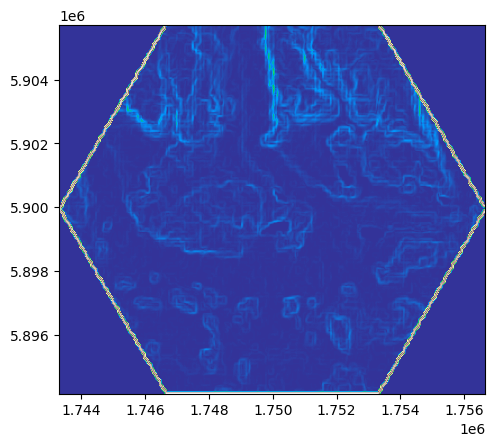

<Axes: >

In [41]:
import rasterio.plot
show(slope_raster, cmap='terrain')

In [83]:
# i don't know why that does not work check: https://numpy.org/doc/stable/user/quickstart.html#quickstart-indexing-slicing-and-iterating
a = slope_raster.read()
b = slope_raster.read()
print(a.mean(),a.std(),a.max(),a.min())
# Areas with a slope > 20% are not suited for cultivation.
i=0
j=0
k=0
while i < len(a):
    while j < len(a[i]):
        while k < len(a[i][j]):
            if a[i][j][k] < 20:
                a[i][j][k] = 0
            k += 1
        j += 1
    i += 1


2.5185876 9.583574 82.55077 0.0


In [119]:
# Areas with a slope > 20% are not suited for cultivation. https://www.researchgate.net/figure/The-mean-of-agricultural-variables-by-steep-slope-groups_tbl1_294105659
# so set all values < 20 to -1000 and count surface area of -1000. can later also check if intersects river
# maxslope = 20 # degrees
maxslope = 10 # degrees

a = slope_raster.read()
w = np.where(((a < maxslope) & (a > 0)), -1000 ,a) # https://note.nkmk.me/en/python-numpy-where/ file:///Users/aljoschabeyer/Library/Mobile%20Documents/iCloud~md~obsidian/Documents/RPG/000%20media/Websites/numpy.where()%20Manipulate%20elements%20depending%20on%20conditions%20note.nkmk.me.html

In [113]:
# https://py.geocompx.org/05-raster-vector#sec-raster-to-polygons
# creates a generator object
shape = rasterio.features.shapes(w, mask=None, transform=slope_raster.transform)
# if you want to list all point in the generator object, if crashes the kernel. This is why ii is a generator object in the first place
pol = list(shape)

In [114]:
geom = [shapely.geometry.shape(i[0]) for i in pol]
geom = gpd.GeoSeries(geom, crs=slope_raster.crs)
geom

0       POLYGON ((1746592.249 5905724.077, 1746592.249...
1       POLYGON ((1746627.453 5905724.077, 1746627.453...
2       POLYGON ((1746662.656 5905724.077, 1746662.656...
3       POLYGON ((1753316.041 5905724.077, 1753316.041...
4       POLYGON ((1753351.244 5905724.077, 1753351.244...
                              ...                        
2467    POLYGON ((1752823.198 5894177.462, 1752823.198...
2468    POLYGON ((1752858.401 5894177.462, 1752858.401...
2469    POLYGON ((1752893.604 5894177.462, 1752893.604...
2470    POLYGON ((1753316.041 5894177.462, 1753316.041...
2471    POLYGON ((1753351.244 5894177.462, 1753351.244...
Length: 2472, dtype: geometry

In [115]:
values = [i[1] for i in pol]
values = pd.Series(values)
values

0       69.471092
1       80.959549
2       74.892891
3       77.182327
4       77.177338
          ...    
2467    81.730713
2468    81.641922
2469    81.538574
2470    77.784950
2471    48.248508
Length: 2472, dtype: float64

In [116]:
result = gpd.GeoDataFrame({'value': values, 'geometry': geom})

In [80]:
result

,value,geometry
0,69.471092,"POLYGON ((1746592.249 5905724.077, 1746592.249..."
1,80.959549,"POLYGON ((1746627.453 5905724.077, 1746627.453..."
2,74.892891,"POLYGON ((1746662.656 5905724.077, 1746662.656..."
3,0.000000,"POLYGON ((1746697.859 5905724.077, 1746697.859..."
4,77.182327,"POLYGON ((1753316.041 5905724.077, 1753316.041..."
...,...,...
93533,81.730713,"POLYGON ((1752823.198 5894177.462, 1752823.198..."
93534,81.641922,"POLYGON ((1752858.401 5894177.462, 1752858.401..."
93535,81.538574,"POLYGON ((1752893.604 5894177.462, 1752893.604..."
93536,77.784950,"POLYGON ((1753316.041 5894177.462, 1753316.041..."


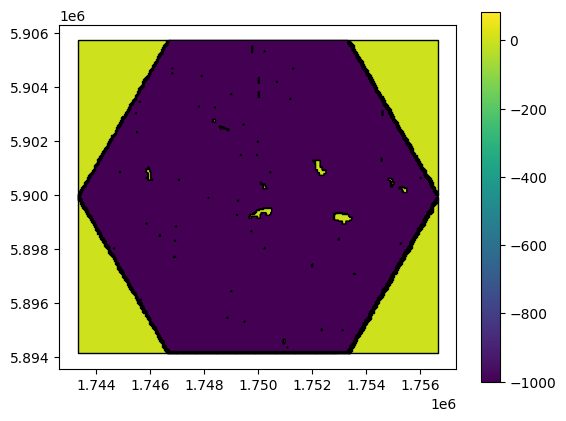

In [117]:
result.plot(column='value', edgecolor='black', legend=True);

In [118]:
result.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHexDEMs_Reprojected/Processed/2.43_slope.shp')

## All in one: Set  flat area in below a cutoff slope (<20%) to -1000 for later processing:

In [126]:
# https://py.geocompx.org/05-raster-vector#sec-raster-to-polygons
slope_raster = rasterio.open('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHexDEMs_Reprojected/Processed/2.43_slope.tif')

# Areas with a slope > 20% are not suited for cultivation. https://www.researchgate.net/figure/The-mean-of-agricultural-variables-by-steep-slope-groups_tbl1_294105659
# so set all values < 20 to -1000 and count surface area of -1000. can later also check if intersects river
maxslope = 20 # degrees
a = slope_raster.read()
w = np.where(((a < maxslope) & (a > 0)), -1000 ,a) # https://note.nkmk.me/en/python-numpy-where/ file:///Users/aljoschabeyer/Library/Mobile%20Documents/iCloud~md~obsidian/Documents/RPG/000%20media/Websites/numpy.where()%20Manipulate%20elements%20depending%20on%20conditions%20note.nkmk.me.html

# https://py.geocompx.org/05-raster-vector#sec-raster-to-polygons
# creates a generator object
shape = rasterio.features.shapes(w, mask=None, transform=slope_raster.transform)
# if you want to list all point in the generator object, if crashes the kernel. This is why ii is a generator object in the first place
pol = list(shape)

geom = [shapely.geometry.shape(i[0]) for i in pol]
geom = gpd.GeoSeries(geom, crs=slope_raster.crs)

values = [i[1] for i in pol]
values = pd.Series(values)

result = gpd.GeoDataFrame({'value': values, 'geometry': geom})

result.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHexDEMs_Reprojected/Processed/2.43_slope.shp')

## Masking a raster layer Tutorial
file:///Users/aljoschabeyer/Downloads/Masking%20_%20clipping%20raster%20%E2%80%94%20Intro%20to%20Python%20GIS%20documentation.html

In [7]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs # pip3 install pycrs

In [242]:
fp =r'/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/Hungary Clips/Merged/HungaryMerged.tif'
data = rasterio.open(fp)

In [175]:
#show(data, cmap='terrain') # cmap='terrain' is a color map, see https://matplotlib.org/stable/tutorials/colors/colormaps.html

### Open 10-mile-hex geometry as bounding box

In [243]:
hexgrid10kmPOLYGONS = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungarybreadRevised.shp')

### Next we need to get the coordinates of the geometry in such a format that rasterio wants them. This can be conducted easily with following function

In [178]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

### Get the geometry coordinates of hex 2.81 by using the function.

In [264]:
hexgrid10kmPOLYGONS.loc[hexgrid10kmPOLYGONS['IDX'] == '2.81','index']

172    172
Name: index, dtype: object

In [284]:

geoIDX = hexgrid10kmPOLYGONS.loc[hexgrid10kmPOLYGONS['IDX'] == '2.81','index'].values[0]
#series_coordsA = getFeatures(geo)
geoIDX =int(geoIDX)
shape_coords = [json.loads(shapely.to_geojson(hexgrid10kmPOLYGONS.loc[geoIDX,'geometry']))]

print(coords)

[{'type': 'Polygon', 'coordinates': [[[1723340.12695709, 5426517.215611564], [1726673.4618445912, 5432290.720995357], [1733340.1316195934, 5432290.720995357], [1736673.4665070944, 5426517.215611564], [1733340.1316195934, 5420743.71022777], [1726673.4618445912, 5420743.71022777], [1723340.12695709, 5426517.215611564]]]}]


### Now we are ready to clip the raster with the polygon using the coords variable that we just created. Clipping the raster can be done easily with the mask function that we imported in the beginning from rasterio, and specifying clip=True.

In [285]:
out_img, out_transform = mask(data, shapes=shape_coords, crop=True) # https://rasterio.readthedocs.io/en/stable/api/rasterio.mask.html

In [286]:
print(out_transform)

| 30.92, 0.00, 1743318.36|
| 0.00,-45.23, 5466942.51|
| 0.00, 0.00, 1.00|


### Next, we need to modify the metadata. Let’s start by copying the metadata from the original data file.

In [287]:
out_meta = data.meta.copy()
print(out_meta)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 47825, 'height': 29500, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["WGS 84 / Pseudo-Mercator",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.922080776664007, 0.0, 1654324.613,
       0.0, -45.22588836005499, 6592253.0628)}


### Next we need to parse the EPSG value from the CRS so that we can create a Proj4 string using PyCRS library (to ensure that the projection information is saved correctly).

In [288]:
# Parse EPSG code
if data.crs.data:
    epsg_code = int(data.crs.data['init'][5:])
    print(epsg_code)
else:
    epsg_code = int(3857) # default to WGS84 Web Mercator (EPSG:3857)
    print('no code found, default to WGS84 Web Mercator (EPSG:3857)')

no code found, default to WGS84 Web Mercator (EPSG:3857)


### Now we need to update the metadata with new dimensions, transform (affine) and CRS (as Proj4 text)

In [289]:
out_meta.update({"driver": "GTiff", "height": out_img.shape[1],"width": out_img.shape[2], "transform": out_transform, "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

### Finally, we can save the clipped raster to disk with following command. 

In [290]:
unproj_hex = r'/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHexDEMs/' + geo['COORDIDX'].values[0]+ r'.tif'

with rasterio.open(unproj_hex, "w", **out_meta) as dest:
    dest.write(out_img)

In [291]:
clipped = rasterio.open(unproj_hex) # file connection

In [292]:
dst_crs = 'EPSG:3857'

In [293]:
dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
    clipped.crs,
    dst_crs,
    clipped.width,
    clipped.height,
    *clipped.bounds
)


In [294]:
dst_kwargs = clipped.meta.copy()
dst_kwargs.update({
    'crs': dst_crs,
    'transform': dst_transform,
    'width': dst_width,
    'height': dst_height
})
dst_kwargs

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 379,
 'height': 329,
 'count': 1,
 'crs': 'EPSG:3857',
 'transform': Affine(35.20309693567769, 0.0, 1743318.3614752386,
        0.0, -35.20309693567769, 5466942.508625112)}

In [295]:
out_tif = r'/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHexDEMs/' + geo['COORDIDX'].values[0]+ r'-3857.tif'
dst_hex = rasterio.open(out_tif, "w", **dst_kwargs)

In [296]:
rasterio.warp.reproject(
    source=rasterio.band(clipped, 1),
    destination=rasterio.band(dst_hex, 1),
    src_transform=clipped.transform,
    src_crs=clipped.crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=rasterio.enums.Resampling.nearest
)

dst_hex.close()
clipped.close()


## The masking proces in a loop for every 10 km hex

In [223]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs # pip3 install pycrs

In [35]:
hexgrid10kmPOLYGONS = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungarybreadRevised.shp')
fp =r'/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/Hungary Clips/Merged/HungaryMerged.tif'
data = rasterio.open(fp)

In [ ]:
#coords = []
column = 2
out_meta = data.meta.copy()
if data.crs.data:
    epsg_code = int(data.crs.data['init'][5:])
    print(epsg_code)
else:
    epsg_code = int(3857) # default to WGS84 Web Mercator (EPSG:3857)
    print('no code found, default to WGS84 Web Mercator (EPSG:3857)')

    
#for i in hexgrid10kmPOLYGONS.index:
for i in hexgrid10kmPOLYGONS.loc[hexgrid10kmPOLYGONS['COORDX'] == column,].index : # only for one column, if you want to do it for all columns, see line above
    #print(hexgrid10kmPOLYGONS.loc[i,'IDX'])
    #print(i)
    hexcoords = hexgrid10kmPOLYGONS.loc[i,'IDX']

    #geoIDX = hexgrid10kmPOLYGONS.loc[hexgrid10kmPOLYGONS['IDX'] == '2.81','index'].values[0]
    #geoIDX =int(geoIDX)
    coords = [json.loads(shapely.to_geojson(hexgrid10kmPOLYGONS.loc[i,'geometry']))]
    out_img, out_transform = mask(data, shapes=coords, crop=True) # https://rasterio.readthedocs.io/en/stable/api/rasterio.mask.html
    
    out_meta.update({"driver": "GTiff", "height": out_img.shape[1],"width": out_img.shape[2], "transform": out_transform, "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    
    # get the bounding box of the slope raster from the metadata. This is the same as slope_raster.bounds. This way there is no need for re-opening a file  connection.
    x_min = out_transform[2]
    y_max = out_transform[5]
    delta_x = out_transform[0]
    delta_y = out_transform[4]
    x_max = x_min + delta_x * out_meta['width']
    y_min = y_max + delta_y * out_meta['height']
    bbox = rasterio.coords.BoundingBox(x_min, y_min, x_max, y_max)
    
    
    #unproj_hex = r'/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHexDEMs/' + hexcoords + r'.tif'

    #with rasterio.open(unproj_hex, "w", **out_meta) as dest:
    #    dest.write(out_img)
    


    #clipped = rasterio.open(unproj_hex) # file connection

    dst_crs = 'EPSG:3857'

    #thisCRS = rasterio.CRS.from_string(out_meta['crs'])


    dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
    #clipped.crs,
    rasterio.CRS.from_string(out_meta['crs']),
    dst_crs,
    #clipped.width,
    out_meta['width'],
    #clipped.height,
    out_meta['height'],
    #*clipped.bounds
    *bbox
    )

    #dst_kwargs = clipped.meta.copy()
    dst_kwargs = out_meta.copy()

    dst_kwargs.update({
    'crs': dst_crs,
    'transform': dst_transform,
    'width': dst_width,
    'height': dst_height
    })
    
    #dst_kwargs
    out_tif = r'/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHexDEMs_Reprojected/' + hexcoords + r'-3857.tif'
    dst_hex = rasterio.open(out_tif, "w", **dst_kwargs)

    rasterio.warp.reproject(
    #source=rasterio.band(clipped, 1),
    source=out_img,
    destination=rasterio.band(dst_hex, 1),
    #src_transform=clipped.transform,
    src_transform=out_transform,
    #src_crs=clipped.crs,
    src_crs=rasterio.CRS.from_string(out_meta['crs']),
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=rasterio.enums.Resampling.nearest
    )

    dst_hex.close()
    #clipped.close()


## For some applications it is necessary to extract the bounds from the transformation matrix. This is how to do it.

In [ ]:
# get the bounding box of the slope raster from the metadata. This is the same as slope_raster.bounds. This way there is no need for re-opening a file  connection.
# https://py.geocompx.org/01-spatial-data#sec-using-rasterio
x_min = slope_raster.meta['transform'][2]
y_max = slope_raster.meta['transform'][5]
delta_x = slope_raster.meta['transform'][0]
delta_y = slope_raster.meta['transform'][4]
x_max = x_min + delta_x * slope_raster.width
y_min = y_max + delta_y * slope_raster.height
slope_raster_bbox = rasterio.coords.BoundingBox(x_min, y_min, x_max, y_max)

## Read Hydrology Raster Data and Convert to Points, Sample flow at point, then make linkes

In [30]:
import sys
import numpy as np
import pandas as pd
sys.path.append('/opt/homebrew/lib/python3.10/site-packages')
sys.path.append('/opt/homebrew/lib/python3.11/site-packages')
sys.path.append('/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages')
import shapely
from shapely.geometry import Point, LineString
import geopandas as gpd
import basemap
import math
import requests
import json
import fiona
from openpyxl import load_workbook
import random
from statistics import mean


#import rasterio.plot
#import rasterio.mask
#import rasterio.features
import rasterstats

#import cfgrib

#%matplotlib inline

# add two empty columns to the river layer
river_hn_lines['flow']= np.empty((len(river_hn_lines), 0)).tolist()
# river_hn_lines['dist']= []
distance_of_sampling_points = 500

dataframe_list = []
line_dataframe_list = []

# take lines, interpolate points, sample raster, add flow to river layer
for i in river_hn_lines.index:
    river_segment = river_hn_lines.loc[i,'geometry']

    river_segment3857 = gpd.GeoSeries(river_segment, crs=4326).to_crs(epsg=3857)
    river_segment3857 = river_segment3857.iloc[0]

    distances = np.arange(0,river_segment3857.length,distance_of_sampling_points)

    river_segment_pnt = [river_segment3857.interpolate(distance) for distance in distances]
    river_segment_pnt = gpd.GeoSeries(river_segment_pnt, crs=3857).to_crs(river_raster.crs)
    result = rasterstats.point_query(river_segment_pnt, river_raster.read(1), nodata = river_raster.nodata, affine = river_raster.transform,interpolate='nearest')
    

    df_river_segment_pnt = gpd.GeoDataFrame(geometry=river_segment_pnt)
    df_river_segment_pnt['dist'] = distances
    df_river_segment_pnt['flow'] = result
    dataframe_list.append(df_river_segment_pnt)

    river_segment_line = river_segment_pnt.copy()

    # create line segments from points, add flow and distances. Thus lines can be plotted with flow as color or line width in QGIS
    if len(river_segment_line) > 1:
        for k in range(len(river_segment_line)-1):
            line = LineString([river_segment_line[k],river_segment_line[k+1]])
            river_segment_line[k] = line
        river_segment_line.drop(k+1, inplace = True)

        df_river_segment_line = gpd.GeoDataFrame(geometry=river_segment_line)
        df_river_segment_line['flow'] = result[:-1]
        df_river_segment_line['dist'] = distances[:-1]
        line_dataframe_list.append(df_river_segment_line)

rdf = gpd.GeoDataFrame(pd.concat(dataframe_list, ignore_index=True), crs=dataframe_list[0].crs)
ldf = gpd.GeoDataFrame(pd.concat(line_dataframe_list, ignore_index=True), crs=line_dataframe_list[0].crs)

ldf.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/hn_rivers_flow_lines.shp')
ldf.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/hn_rivers_flow_lines.gpkg')
rdf.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/hn_rivers_flow_points.shp')
rdf.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/hn_rivers_flow_points.gpkg')

## Find Hexes with large Bodies of Water for Coins = INTERSECT CORINE CODE 90 512 OR 523 WITH THE HEXGRID

Hammers are harder. Cultivated vs Mined: sjoin Rivers, sjoin corine land cover. Arable land? Hex Type 7 6 or 5? Add one hammer if settlement
Coins also Cultivated vs mined. Also Oasis

# Find Hexes with any rivers for well-watered areas = cultivated hexes. THIS DOES NOT EXCLUDE MOUNTAIN VALLEYS

In [104]:
# Read in hexgrid and add river flow to hexes
hexgrid10km = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungary Copy with Bread.shp')
river_flow_lines = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/hn_rivers_flow_lines.shp')
hexgrid10kmPOINTS = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10km Hex Features all.shp')
# Filter river flow for large rivers and set CRS
any_rivers = river_flow_lines.loc[river_flow_lines['flow'] > 1]
any_rivers = any_rivers.to_crs(hexgrid10km.crs)
# Add river flow to hexgrid https://geopandas.org/en/stable/gallery/spatial_joins.html
# then only retain the first match
hexes_with_any_rivers = gpd.sjoin(hexgrid10km, any_rivers, how ="inner", predicate='contains')
hexes_with_any_rivers.drop_duplicates(subset='IDX', keep='first', inplace=True) # this is what i want.

hexgrid10kmPOINTS['anyRiver'] = 0 * hexgrid10kmPOINTS.shape[0] #initialize new column
for i in hexgrid10kmPOINTS[hexgrid10kmPOINTS['IDX'].isin(hexes_with_any_rivers['IDX'])].index:
    #print(i)
    #print(hexgrid10kmPOINTS.loc[i,'anyRiver'])
    hexgrid10kmPOINTS.loc[i,'anyRiver'] = 1
    #print(hexgrid10kmPOINTS.loc[i,'anyRiver'])

hexgrid10kmPOINTS.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10km Hex Features all.shp')


## Find Hexes with large Rivers for Hammers and Coins
might be easier if done in QGIS but need data later on for calculation of Hammers and Coins

In [ ]:
# Read in hexgrid and add river flow to hexes
hexgrid10km = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungary Copy with Bread.shp')
river_flow_lines = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/hn_rivers_flow_lines.shp')
hexgrid10kmPOINTS = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10km Hex Features all.shp')


In [13]:
# Filter river flow for large rivers and set CRS
large_rivers = river_flow_lines.loc[river_flow_lines['flow'] > 49]
large_rivers = large_rivers.to_crs(hexgrid10km.crs)


In [114]:
# Add river flow to hexgrid https://geopandas.org/en/stable/gallery/spatial_joins.html
# then only retain the first match
hexes_with_large_rivers = gpd.sjoin(hexgrid10km, large_rivers, how ="inner", predicate='contains')
hexes_with_large_rivers.drop_duplicates(subset='IDX', keep='first', inplace=True) # this is what i want.



In [ ]:
hexgrid10kmPOINTS['largeRiver'] = 0 * hexgrid10kmPOINTS.shape[0] #initialize new column
for i in hexgrid10kmPOINTS[hexgrid10kmPOINTS['IDX'].isin(hexes_with_large_rivers['IDX'])].index:
    print(i)
    print(hexgrid10kmPOINTS.loc[i,'largeRiver'])
    hexgrid10kmPOINTS.loc[i,'largeRiver'] = 1
    print(hexgrid10kmPOINTS.loc[i,'largeRiver'])



In [123]:
hexgrid10kmPOINTS.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10km Hex Features all.shp')

/var/folders/0b/fbk22xnd4gs9_s54ynyblwtc0000gn/T/ipykernel_17508/3997959370.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hexgrid10kmPOINTS.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10km Hex Features all.shp')


## Find largest Ecoregion in 10km hexes

In [ ]:
# Find largest Ecoregion in 10km hexes by area and write the name (an in the future maybe the ID) to the 10km hexes
hexgrid10kmPOLYGONS = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungarybreadRevised.shp')

hexgrid10kmPOINTS = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10km Hex Features all.shp')

ecoregions_subset = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/Ecoregions subset.shp')
ecoregions_subset = ecoregions_subset.to_crs('EPSG:3857')
largest_ecoregion_in_10kmhexes = {}
for hex in hexgrid10kmPOLYGONS[pd.notna(hexgrid10kmPOLYGONS.geometry)].iterrows():
    ecoregions_in_hexNAME = {}
    ecoregions_in_hexID = {}
    for ecoregion in ecoregions_subset.iterrows():
        intersects = shapely.intersection(ecoregion[1].geometry, hex[1].geometry)
        if intersects.area != 0:
            ecoregions_in_hexNAME[ecoregion[1]['ECO_NAME']] = intersects.area
            ecoregions_in_hexID[ecoregion[1]['ECO_ID']] = intersects.area
    #print(ecoregions_in_hex)
    if ecoregions_in_hexNAME != {}: # can be empty if there is no ecoregion (in the sea)
        largest_ecoregion_in_this_hexNAME = max(ecoregions_in_hexNAME, key = ecoregions_in_hexNAME.get) #https://docs.python.org/3/library/functions.html#max, max accepts a keyword argument to preprocess the values
        largest_ecoregion_in_this_hexID = max(ecoregions_in_hexID, key = ecoregions_in_hexID.get)
        largest_ecoregion_in_10kmhexes[hex[1]['IDX']]= [largest_ecoregion_in_this_hexNAME,largest_ecoregion_in_this_hexID]
#print(largest_ecoregion_in_10kmhexes)


hexgrid10kmPOINTS['ECO_NAME'] = '' * hexgrid10km.shape[0]
hexgrid10kmPOINTS['ECO_ID'] = 0 * hexgrid10km.shape[0]
for key, value in largest_ecoregion_in_10kmhexes.items():
    hexgrid10kmPOINTS.loc[hexgrid10kmPOINTS['IDX'] == key, 'ECO_NAME'] = value[0]
    hexgrid10kmPOINTS.loc[hexgrid10kmPOINTS['IDX'] == key, 'ECO_ID'] = value[1]

hexgrid10kmPOINTS.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10km Hex Features all.shp')

# Mark Hexes with large Lakes for Coin Calculation. ## Find Hexes with large Bodies of Water for Coins = INTERSECT CORINE CODE 90 512 OR 523 WITH THE HEXGRID

In [9]:
corine= gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/u2000_clc1990_v2020_20u1_geoPackage/DATA/U2000_CLC1990_V2020_20u1.gpkg', layer='u2000_clc1990_v2020_20u1')

In [ ]:
hexgrid10kmPOLYGONS = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungarybreadRevised.shp')

hexgrid10kmPOINTS = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10km Hex Features all.shp')


In [11]:
corine.to_crs('EPSG:3857', inplace = True)

In [94]:
large_lakes = corine.loc[corine['Area_Ha'] > 1000]

In [95]:
large_lakes = large_lakes.loc[((large_lakes['code_90'] == '523') | (large_lakes['code_90'] == '512'))]


In [89]:
hexes_with_large_lakes = gpd.sjoin(hexgrid10kmPOLYGONS, large_lakes, how ="inner", predicate='intersects')
hexes_with_large_lakes.drop_duplicates(subset='IDX', keep='first', inplace=True) # this is what i want.

In [ ]:
hexgrid10kmPOINTS['largeLake'] = 0 * hexgrid10kmPOINTS.shape[0] #initialize new column
for i in hexgrid10kmPOINTS[hexgrid10kmPOINTS['IDX'].isin(hexes_with_large_lakes['IDX'])].index:
    # print(i)
    # print(hexgrid10kmPOINTS.loc[i,'largeLake'])
    hexgrid10kmPOINTS.loc[i,'largeLake'] = 1
    # print(hexgrid10kmPOINTS.loc[i,'largeLake'])

In [33]:
hexgrid10kmPOINTS.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10km Hex Features all.shp')

# set_hammers findig cultivated is fuzzy

In [135]:
# set_hammers
# Any type of hex from 1 to 7, that appears in a well-watered valleys, hills or plains, is considered cultivated. SO I CHECK FOR THE PRESENCE OF A RIVER OR A LAKE
# In addition to the coins added by type, an additional +1 coin is awarded if the hex is located on a body of water that's at least four square miles in area, AND if the hex is a type 1 to 6 hex. The amount of land on the hex must also equal at least 4 square miles. Thus, lakeshores and coastal hexes collect more coins, thus having more active economies than inland hexes. Water-borne trade brings many more customers and is much more interesting as a place to invest. 
# A +1 coin is also given for each settlement a hex includes. SO CHECK FOR THE PRESENCE OF A SETTLEMENT.
# maybe go for a minimum area without stark slopes?

def set_hammers(hexgrid10kmPOINTS):
    hammers = {'cultivated' : {'0': -1,'1': 4, '2':4, '3':3 , '4':2, '5':1, '6':1, '7': 0, '8':0 },
            'mined' : {'0': -1,'1': -2, '2':-2, '3': -2, '4':-2, '5':3, '6':2, '7': 2, '8': 0}
            }

    hexgrid10kmPOINTS['hammers'] = 0 * hexgrid10kmPOINTS.shape[0] #initialize new column
    hexgrid10kmPOINTS['cultivated'] = 0 * hexgrid10kmPOINTS.shape[0] #initialize new column
    hexgrid10kmPOINTS['mined'] = 0 * hexgrid10kmPOINTS.shape[0] #initialize new column
    for i in hexgrid10kmPOINTS.index:
        # if any([pd.notna(hexgrid10km.loc[i,'main_commo']), pd.notna(hexgrid10km.loc[i,'commodity']),pd.notna(hexgrid10km.loc[i,'IDminingfe'])]):
        # hexgrid10km.loc[i,'Bread'] = -1
        # Hextype of corner hexes is 0!
        if hexgrid10kmPOINTS.loc[i, 'anyRiver'] == 1: # surrogate parameter for well-watered valleys, hills or plains, assuming that riverrs in mountains are smaller
            hexgrid10kmPOINTS.loc[i,'cultivated'] = 1
            hexgrid10kmPOINTS.loc[i,'hammers'] = hammers['cultivated'][hexgrid10kmPOINTS.loc[i,'HexType'].astype(int).astype(str)]
        if pd.notna(hexgrid10kmPOINTS.loc[i, 'label']):
            hexgrid10kmPOINTS.loc[i,'mined'] = 1
            hexgrid10kmPOINTS.loc[i,'hammers'] = hammers['mined'][hexgrid10kmPOINTS.loc[i,'HexType'].astype(int).astype(str)]
        if pd.notna(hexgrid10kmPOINTS.loc[i,'IDsettl']):
            hexgrid10kmPOINTS.loc[i,'hammers'] += 1
        if hexgrid10kmPOINTS.loc[i, 'largeRiver'] == 1:
            hexgrid10kmPOINTS.loc[i,'hammers'] += 1 # In addition to the hammers added by type, an additional +1 hammer is awarded if the hex includes a sufficiently sized river.
    return hexgrid10kmPOINTS

hexgrid10kmPOINTS = set_hammers(hexgrid10kmPOINTS)
hexgrid10kmPOINTS.to_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10km Hex Features all.shp')

# set_coins

In [32]:
# Read in, now truncated colum lables
# Any type of hex from 1 to 7, that appears in a well-watered valleys, hills or plains, is considered cultivated. SO I CHECK FOR THE PRESENCE OF A RIVER OR A LAKE
# In addition to the coins added by type, an additional +1 coin is awarded if the hex is located on a body of water that's at least four square miles in area, AND if the hex is a type 1 to 6 hex. The amount of land on the hex must also equal at least 4 square miles. Thus, lakeshores and coastal hexes collect more coins, thus having more active economies than inland hexes. Water-borne trade brings many more customers and is much more interesting as a place to invest. 
# A +1 coin is also given for each settlement a hex includes. SO CHECK FOR THE PRESENCE OF A SETTLEMENT.

def set_coins(hexgrid10kmPOINTS):
    coins = {'cultivated' : {'0': -1,'1': 5, '2':3, '3':2 , '4':1, '5':0, '6':0, '7': 0, '8':0 },
            'mined' : {'0': -1,'1': -2, '2':-2, '3': -2, '4':-2, '5':1, '6':1, '7': 0, '8': 0},
            'oasis' : {'0': -1,'1': 6, '2':4, '3': 3, '4':2, '5':0, '6':0, '7': 0, '8': 0}
             }

    hexgrid10kmPOINTS['coins'] = 0 * hexgrid10kmPOINTS.shape[0] #initialize new column
    for i in hexgrid10kmPOINTS.index:
        hexgrid10kmPOINTS.loc[i,'coins'] = 0
        # if any([pd.notna(hexgrid10km.loc[i,'main_commo']), pd.notna(hexgrid10km.loc[i,'commodity']),pd.notna(hexgrid10km.loc[i,'IDminingfe'])]):
        # hexgrid10km.loc[i,'Bread'] = -1
        # Hextype of corner hexes is 0!

        if hexgrid10kmPOINTS.loc[i,'cultivated'] == 1:
            hexgrid10kmPOINTS.loc[i,'coins'] = coins['cultivated'][hexgrid10kmPOINTS.loc[i,'HexType'].astype(int).astype(str)]
        if hexgrid10kmPOINTS.loc[i,'mined'] == 1:
            hexgrid10kmPOINTS.loc[i,'coins'] = coins['mined'][hexgrid10kmPOINTS.loc[i,'HexType'].astype(int).astype(str)]

        if pd.notna(hexgrid10kmPOINTS.loc[i,'IDsettl']):
            hexgrid10kmPOINTS.loc[i,'coins'] += 1

        if ((hexgrid10kmPOINTS.loc[i, 'largeLake'] == 1) and (hexgrid10kmPOINTS.loc[i, 'HexType'] < 7)):
            hexgrid10kmPOINTS.loc[i,'coins'] += 1 # In addition to the hammers added by type, an additional +1 hammer is awarded if the hex includes a sufficiently sized river.

    return hexgrid10kmPOINTS

hexgrid10kmPOINTS = set_coins(hexgrid10kmPOINTS)

In [11]:
hexgrid10km = gpd.read_file('/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/10kmHungarybreadRevised.shp')

In [12]:
hexgrid30km = gpd.read_file("/Users/aljoschabeyer/Library/Mobile Documents/iCloud~md~obsidian/Documents/RPG/000 media/Maps/QGIS/30KMHungaryClip.shp")

In [14]:
hexgrid30km.head()

,COORDIDX,left,bottom,right,top,ID,COORDX,COORDY,settlement,MeanElev,Area,Infrastruc,settl,Infra,update,OriginalIn,geometry
0,0,1.690010e+06,5.443838e+06,1.730010e+06,5.478479e+06,835077,723,419,NaN,21.484527707561433,301,NaN,NaN,0,0,0,"POLYGON ((1720010.127 5443838.226, 1726675.908..."
1,1,1.720010e+06,5.426518e+06,1.760010e+06,5.461159e+06,836231,724,419,NaN,63.171818871307345,301,NaN,NaN,0,0,0,"POLYGON ((1730010.132 5426517.710, 1720010.127..."
2,2,1.750010e+06,5.409197e+06,1.790010e+06,5.443838e+06,837384,725,420,NaN,65.99927507501451,301,NaN,NaN,0,0,0,"POLYGON ((1750010.141 5426517.710, 1750010.141..."
3,3,1.750010e+06,5.443838e+06,1.790010e+06,5.478479e+06,837385,725,419,NaN,229.92742804596253,301,NaN,NaN,0,0,0,"POLYGON ((1780010.155 5443838.226, 1760010.146..."
4,4,1.690010e+06,5.478479e+06,1.730010e+06,5.513120e+06,835078,723,418,NaN,108.50503586706147,301,NaN,NaN,0,0,0,"POLYGON ((1720010.127 5478479.259, 1720010.127..."


In [9]:
def edge_hex_type(hexgrid30km,hexgrid10km):

    # needs hex groups in 10 km hexes
    filt = hexgrid30km['Edge_Hexes'].str.len() !=0 # check if str is empty,
    # hexgrid30km['Edge_Hexes'] from small_hexes_in_big_hexes(hexgrid30km):

    Edge_Hexes_on_grid = []

    for Edge_Hex_ListJSON in hexgrid30km.loc[filt,'Edge_Hexes']:
        Edge_Hex_List = json.loads(Edge_Hex_ListJSON)
        for Edge_Hex in Edge_Hex_List:
            if Edge_Hex in hexgrid10km.index:
                Edge_Hexes_on_grid.append(Edge_Hex)

    Edge_Hexes_on_grid = list(set(Edge_Hexes_on_grid)) # removes duplicates

    # has been updated, should work now
    COORDIDX_10km_Edge_Hex = {}
    ring_hex_types = []
    for this_Edge_Hex in Edge_Hexes_on_grid:
        ring_around_Edge = hex_group(this_Edge_Hex,1)
        for ring_hex in ring_around_Edge:
            if ring_hex in hexgrid10km['IDX'].to_list():
                # if ring_hex in COORDIDX_10km_HexGroup: # where in 10km grid or 30 km grid
                ring_hex_types.append(hexgrid10km.loc[hexgrid10km['IDX'] == ring_hex,'HexType'].to_list()[0]) # to_list() because it returns a series
                # else:
                    #print(ring_hex, 'not on Grid')
                    # pass
        if len(ring_hex_types) != 0:
            mean_type = round(mean(ring_hex_types))
        print("before: ", hexgrid10km.loc[hexgrid10km['IDX'] == this_Edge_Hex,'HexType'])    
        hexgrid10km.loc[hexgrid10km['IDX'] == this_Edge_Hex,'HexType'] = mean_type
        print("after:", hexgrid10km.loc[hexgrid10km['IDX'] == this_Edge_Hex,'HexType'])
        ring_hex_types = []

    return hexgrid10km

In [10]:
edge_hex_type(hexgrid30km,hexgrid10km)

KeyError: 'Edge_Hexes'